# GAIA PSF Simulation

First attempt to simulate close binary stars observation using the gaia telescope. The latter is imagined as a rectangular pupil, with no pixel binning or aberrations

#### Initialization

In [7]:
from matplotlib import pyplot as plt
import numpy as np

## The simulator

The idea of the `SimulatorV0` is to simply create a map of close point-like sources, spanning different angles and separations, to convolve with a constructed (very simplified) _Gaia_ PSF (created with `Poppy`)

### The Poppy optical system

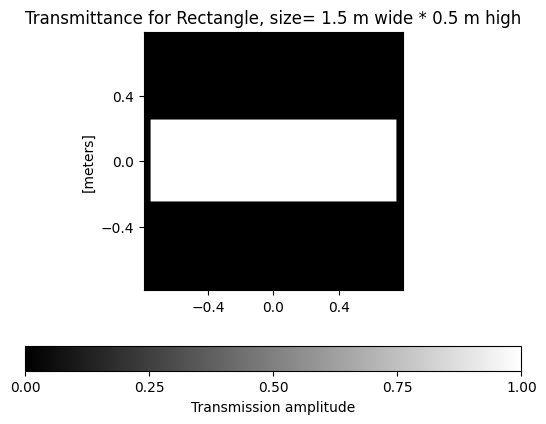

In [2]:
## template for GAIA PSF
import poppy
import astropy.units as u
osys = poppy.OpticalSystem()

#parameters
#off axis == no secondary obstruction
apert_w = 1.5 #m
apert_h = 0.5 #m
pixscale_x = 0.05
pscale_fact = 2 #pixscale_y/pixscale_x
pixscale_y = pixscale_x*pscale_fact
field_ofview = 5 #arcsec
wavel_pfs = 550e-9

optic = poppy.RectangleAperture(width=apert_w*u.m, height=apert_h*u.m)
osys.add_pupil(optic)
osys.display()

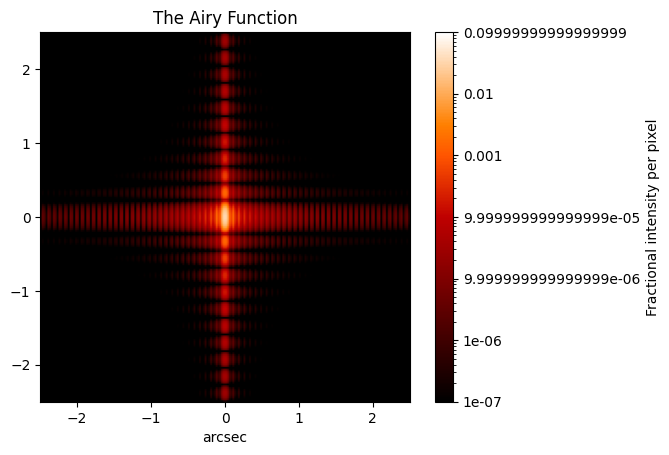

In [3]:
osys.add_detector(pixelscale=pixscale_x, fov_arcsec=field_ofview)  # image plane coordinates in arcseconds
psf_hud = osys.calc_psf(wavel_pfs)                            # wavelength in meters
poppy.display_psf(psf_hud, title='The Airy Function')
img = psf_hud[0].data
psf = poppy.utils.rebin_array(img, (1,pscale_fact))

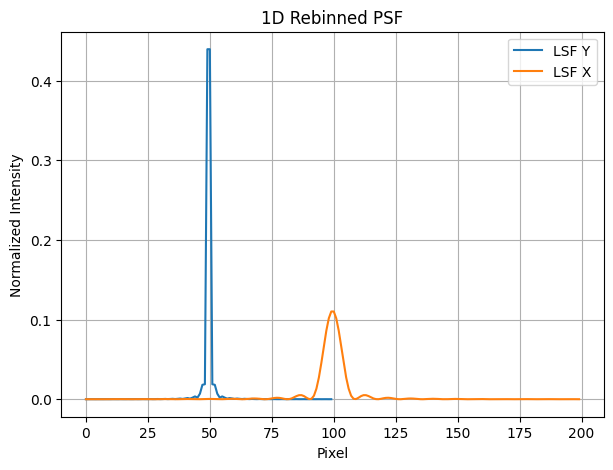

In [4]:
lsf_y = np.sum(psf, axis=0)  # or axis=1, depending on scan direction
lsf_y /= np.sum(lsf_y)  # normalize

lsf_x = np.sum(psf, axis=1)  # or axis=0, depending on scan direction
lsf_x /= np.sum(lsf_x)  # normalize

plt.figure(figsize=(7, 5))
plt.title('1D Rebinned PSF')
plt.plot(lsf_y  , label='LSF Y')
plt.plot(lsf_x, label='LSF X')
plt.xlabel('Pixel')
plt.ylabel('Normalized Intensity')
plt.legend()
plt.grid()
plt.show()

So, now we have a LSF resembling that of Gaia, that we have to convolve with the produced map of sources

In [13]:
from scipy.ndimage import zoom

def resample_sky_to_detector(sky_map, sky_pixscale, detector_shape, detector_pixscale):
    """
    Resample the sky map to match the detector's pixel scale and shape.
    """
    scale_factor = sky_pixscale / detector_pixscale
    zoom_factors = (detector_shape[0] / sky_map.shape[0], detector_shape[1] / sky_map.shape[1])
    resampled_sky = zoom(sky_map, zoom_factors, order=1)
    return resampled_sky

# Example usage:
sky_pixscale = 0.01  # arcsec/pixel (sky map)
detector_pixscale = 0.05  # arcsec/pixel (poppy)
detector_shape = (128, 128)
resampled_sky = resample_sky_to_detector(sky_map, sky_pixscale, detector_shape, detector_pixscale)

/home/pietrof/miniforge3/lib/python3.12/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


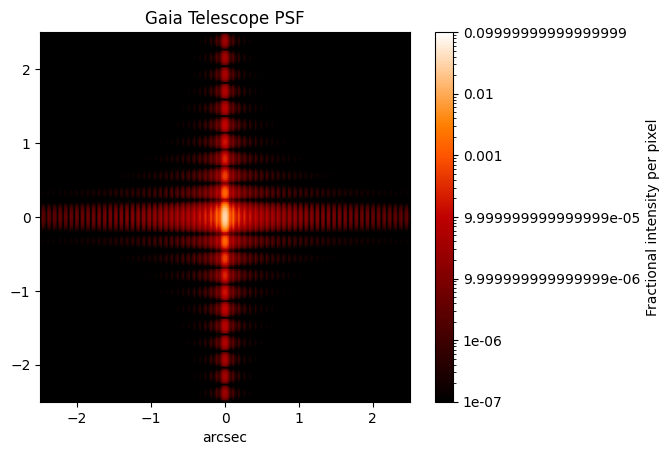

In [1]:
from simulator import SkyMap, GaiaTelescopeV0
from matplotlib import pyplot as plt
import numpy as np
sm = SkyMap(map_noise=5)
gt = GaiaTelescopeV0()
gt.display_psf()
sssm = sm.create_single_star_sky_map(10, (128,128))

In [2]:
map =gt.observeSkyMap(sssm)

100
50
1 shift=50
2 shift=100
3 shift=150
4 shift=200
5 shift=250
6 shift=300
7 shift=350
8 shift=400
9 shift=450
10 shift=500
11 shift=550
12 shift=600
13 shift=650
14 shift=700
15 shift=750
16 shift=800
17 shift=850
18 shift=900
19 shift=950
20 shift=1000
21 shift=1050
22 shift=1100
23 shift=1150
24 shift=1200
25 shift=1250
26 shift=1300
27 shift=1350
28 shift=1400
29 shift=1450
30 shift=1500
31 shift=1550
32 shift=1600
33 shift=1650
34 shift=1700
35 shift=1750
36 shift=1800
37 shift=1850
38 shift=1900
39 shift=1950
40 shift=2000
41 shift=2050
42 shift=2100
43 shift=2150
44 shift=2200
45 shift=2250
46 shift=2300
47 shift=2350
48 shift=2400
49 shift=2450
50 shift=2500
51 shift=2550
52 shift=2600
53 shift=2650
54 shift=2700
55 shift=2750
56 shift=2800
57 shift=2850
58 shift=2900
59 shift=2950
60 shift=3000
61 shift=3050
62 shift=3100
63 shift=3150
64 shift=3200
65 shift=3250
66 shift=3300
67 shift=3350
68 shift=3400
69 shift=3450
70 shift=3500
71 shift=3550
72 shift=3600
73 shift=3650


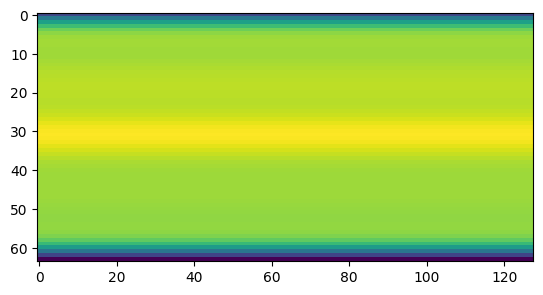

In [3]:
plt.imshow(map)

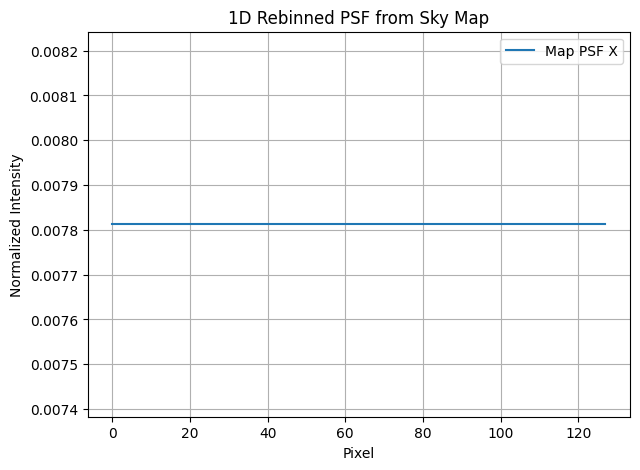

In [7]:
map_psf_x = np.sum(map, axis=0)  # or axis=1, depending on scan direction
map_psf_x /= np.sum(map_psf_x)  # normalize
map_psf_y = np.sum(map, axis=1)  # or axis=0, depending on scan direction
map_psf_y /= np.sum(map_psf_y)  # normalize
plt.figure(figsize=(7, 5))
plt.title('1D Rebinned PSF from Sky Map')
plt.plot(map_psf_x, label='Map PSF X')
##plt.plot(map_psf_y, label='Map PSF Y')
plt.legend()
plt.xlabel('Pixel')
plt.ylabel('Normalized Intensity')
plt.grid()
plt.show()